# Анализ поведения покупателей и разработка стратегии повышения активности клиентов

## Цели проекта

- Провести анализ данных о поведении покупателей, включая коммуникацию, продуктовое, покупательское и онлайн-поведение.
- Построить модель прогнозирования уровня снижения активности клиентов на основе исторических данных.
- Выявить ключевые факторы, влияющие на активность клиентов, с использованием методов интерпретируемости модели, таких как SHAP.
- Выполнить сегментацию покупателей на основе их поведения, прибыльности и активности.
- Предложить рекомендации для выбранных сегментов покупателей для увеличения их вовлечённости и активности:
    - Разработать стратегии персонализации маркетинга.
    - Оптимизировать процесс взаимодействия с клиентами через сайт и сервис.
- Сформулировать выводы о сегментах и предложить бизнес-решения для долгосрочного удержания клиентов.

In [1]:
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 13.5 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 89.9 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [3]:
!pip install shap

     |████████████████████████████████| 539 kB 1.2 MB/s eta 0:00:01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import resources
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from scipy import stats as st
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
import shap
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier

## Описание данных
`market_file.csv` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv` - данные о выручке, которую получает магазин с покупателя
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, `'текущий_месяц'` или `'предыдущий_месяц'`.
- `Выручка` — сумма выручки за период.

`market_time.csv` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv` - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.


### Загрузка данных

In [5]:
market_file_df = pd.read_csv('/datasets/market_file.csv')
market_money_df = pd.read_csv('/datasets/market_money.csv')
market_time_df = pd.read_csv('/datasets/market_time.csv')
money_df = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

Взглянем на первые строки каждого датасета для визуальной оценки данных

In [6]:
market_file_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Анализ данных

Взглянем на общую информацию о каждом датасете

In [10]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Для датасета `market_file_df`:
- Пропуски в данных отсуствуют
- Типы данных корректны

In [11]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Для датасета `market_money_df`:
- Пропуски в данных отсуствуют
- Типы данных корректны

In [12]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Для датасета `market_time_df`:
- Пропуски в данных отсуствуют
- Типы данных корректны

In [13]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Для датасета `money_df`:
- Пропуски в данных отсуствуют
- Типы данных корректны

### Вывод

Данные из всех предоставленных файлов успешно загружены. Форматы данных соответствуют описанию. Пропуски в столбцах отсутствуют, типы данных корректны. Переходим к этапу предобработки данных.

## Предобработка данных

### Переименование колонок

Для упрощения работы с датасетами переименуем колонки и приведем их все к единому виду: латиница и snake-case

Для датасета `market_file_df` будем использовать следующие названия колонок:
- `Покупательская активность` — `buying_activity`
- `Тип сервиса` — `service_type`
- `Разрешить сообщать` — `messages_allowed`
- `Маркет_актив_6_мес` — `marketing_6_mon_avg`
- `Маркет_актив_тек_мес` — `marketing_curr_mon`
- `Длительность` — `duration`
- `Акционные_покупки` — `promo_purchases`
- `Популярная_категория` — `favourite_cat`
- `Средний_просмотр_категорий_за_визит` — `session_cat_avg`
- `Неоплаченные_продукты_штук_квартал` — `card_items_quorter_avg`
- `Ошибка_сервиса` — `downtime_count`
- `Страниц_за_визит` — `session_pages_avg`

In [14]:
# Переименование колонок в датасете market_file_df
market_file_df = market_file_df.rename(columns = {
    'Покупательская активность': 'buying_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'messages_allowed',
    'Маркет_актив_6_мес': 'marketing_6_mon_avg',
    'Маркет_актив_тек_мес': 'marketing_curr_mon',
    'Длительность': 'duration',
    'Акционные_покупки': 'promo_purchases',
    'Популярная_категория': 'favourite_cat',
    'Средний_просмотр_категорий_за_визит': 'session_cat_avg',
    'Неоплаченные_продукты_штук_квартал': 'card_items_quorter_avg',
    'Ошибка_сервиса': 'downtime_count',
    'Страниц_за_визит': 'session_pages_avg'})
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1300 non-null   int64  
 1   buying_activity         1300 non-null   object 
 2   service_type            1300 non-null   object 
 3   messages_allowed        1300 non-null   object 
 4   marketing_6_mon_avg     1300 non-null   float64
 5   marketing_curr_mon      1300 non-null   int64  
 6   duration                1300 non-null   int64  
 7   promo_purchases         1300 non-null   float64
 8   favourite_cat           1300 non-null   object 
 9   session_cat_avg         1300 non-null   int64  
 10  card_items_quorter_avg  1300 non-null   int64  
 11  downtime_count          1300 non-null   int64  
 12  session_pages_avg       1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


Для датасета `market_money_df` будем использовать следующие названия колонок:
- `Период` — `period`
- `Выручка` — `revenue`

In [15]:
# Переименование колонок в датасете market_money_df
market_money_df = market_money_df.rename(columns = {
    'Период': 'period',
    'Выручка': 'revenue'})
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Для датасета `market_time_df` будем использовать следующие названия колонок:
- `Период` — `period`
- `минут` — `mins`

In [16]:
# Переименование колонок в датасете market_time_df
market_time_df = market_time_df.rename(columns = {
    'Период': 'period',
    'минут': 'mins'})
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   period  2600 non-null   object
 2   mins    2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Для датасета `money_df` будем использовать следующие названия колонок:
- `Прибыль` — `income`

In [17]:
# Переименование колонок в датасете money_df
money_df = money_df.rename(columns = {'Прибыль': 'income'})
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   income  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Предобработка категориальных значений

Взглянем на то, какие категории представлены в различных категориальных колонках всех датасетов. Прежде чем начать работу с категориальными значениями, приведем их все к единому виду: удалим лишние пробелы, при наличии, и приведем все значения к нижнему регистру.

In [18]:
# Составим список всех строковых категориальных значений датасета market_file_df
market_file_df_cat = ['buying_activity', 'service_type', 'messages_allowed', 'favourite_cat']

# Удалим пробелы и приведем значения к нижнему регистру
for cat_columns in market_file_df_cat:
    market_file_df[cat_columns] = market_file_df[cat_columns].str.strip().str.lower()

# Для датасетов market_money_df и market_time_df повторим операцию для колонки period
market_money_df['period'] = market_money_df['period'].str.strip().str.lower()
market_time_df['period'] = market_time_df['period'].str.strip().str.lower()

In [19]:
# Проверим покупательную активность пользователей
market_file_df['buying_activity'].value_counts()

прежний уровень    802
снизилась          498
Name: buying_activity, dtype: int64

Категорий всего две как и должно быть. Присутствует дисбаланс классов. Записей для покупателей с "прежним уровнем" активности  почти вдвое больше.

In [20]:
# Проверим типы сервиса
market_file_df['service_type'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: service_type, dtype: int64

Есть опечатка в 10 строках со значением `стандарт`. Исправим ошибочные значения

In [21]:
# Заменим 'стандартт' на 'стандарт'
market_file_df['service_type'] = market_file_df['service_type'].replace({'стандартт': 'стандарт'})
# Проверим типы сервиса
market_file_df['service_type'].value_counts()

стандарт    924
премиум     376
Name: service_type, dtype: int64

In [22]:
# Проверим значения в колонке 'messages_allowed'
market_file_df['messages_allowed'].value_counts()

да     962
нет    338
Name: messages_allowed, dtype: int64

In [23]:
# Проверим любимые категории пользователей
market_file_df['favourite_cat'].value_counts()

товары для детей                        330
домашний текстиль                       251
косметика и аксесуары                   223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: favourite_cat, dtype: int64

Любимые категории пользователей выглядят корректно и не требуют исправлений.

In [24]:
market_money_df['period'].value_counts()

текущий_месяц          1300
предыдущий_месяц       1300
препредыдущий_месяц    1300
Name: period, dtype: int64

В датасете представлены три периода, за которые зафиксирована выручка. Оставим их как есть, исправления не требуются.

In [25]:
market_time_df['period'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: period, dtype: int64

Среди периодов, в которые зафиксировано общее время, видим опечатку в значении `предыдущий_месяц`. Исправим.

In [26]:
# Заменим 'предыдцщий_месяц' на 'предыдущий_месяц'
market_time_df['period'] = market_time_df['period'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
# Проверим типы сервиса
market_time_df['period'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: period, dtype: int64

Все категориальные значения обработаны, ошибки исправлены. Можем переходить к проверке датасетов на дубликаты.

### Проверка на дубликаты

In [27]:
# Проверим наличие явных дубликатов в датасете market_file_df
market_file_df.duplicated().sum()

0

In [28]:
# Проверим наличие явных дубликатов в датасете market_file_df
market_money_df.duplicated().sum()

0

In [29]:
# Проверим наличие явных дубликатов в датасете market_time_df
market_time_df.duplicated().sum()

0

In [30]:
# Проверим наличие явных дубликатов в датасете money_df
money_df.duplicated().sum()

0

Явных дубликатов в данных не обнаружено, можем двигаться дальше.

### Вывод по разделу предобработки данных

В ходе предобработки данных были выполнены следующие шаги:

1. **Переименование колонок**: Все названия колонок в датасетах приведены к единому стилю: латиница и snake-case, что упрощает работу с данными.
2. **Обработка категориальных значений**:
    - Все категориальные значения приведены к единому виду: удалены лишние пробелы и применен нижний регистр.
    - Исправлены опечатки, выявленные в категориальных колонках, таких как `service_type` и `period`.
3. **Проверка на пропуски**: - Пропуски в данных отсутствуют, что было подтверждено на этапе ознакомления с данными через метод `info()`.
4. **Проверка данных на дубликаты**: - Дубликатов в датасетах обнаружено не было.

В результате предобработки данные подготовлены для дальнейшего анализа и моделирования. Все обнаруженные ошибки исправлены, структуры данных унифицированы.

## Исследовательский анализ данных

### Анализ числовых данных

#### Распределение данных датасета `market_file_df`

In [31]:
# Получим основные статистические характеристики для численных переменных датасета market_file_df
numeric_features = ['marketing_6_mon_avg', 'marketing_curr_mon', 'duration', 'promo_purchases',
                    'session_cat_avg', 'card_items_quorter_avg', 'downtime_count', 'session_pages_avg']

market_file_df[numeric_features].describe()

,marketing_6_mon_avg,marketing_curr_mon,duration,promo_purchases,session_cat_avg,card_items_quorter_avg,downtime_count,session_pages_avg
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Визуализируем распределения количественных признаков по целевому признаку (`buying_activity`)

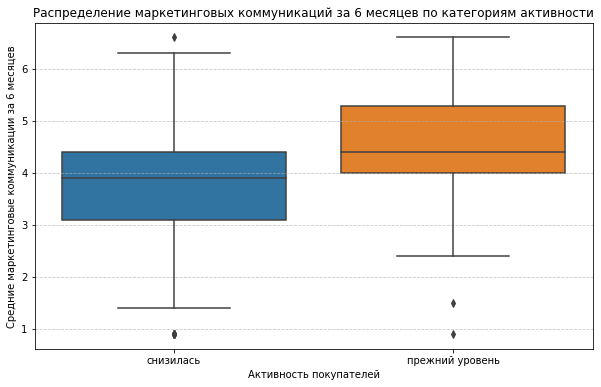

In [32]:
# График распределения marketing_6_mon_avg по группам buying_activity
plt.figure(figsize=(10, 6))
sns.boxplot(x='buying_activity', y='marketing_6_mon_avg', data=market_file_df)
plt.title('Распределение маркетинговых коммуникаций за 6 месяцев по категориям активности')
plt.xlabel('Активность покупателей')
plt.ylabel('Средние маркетинговые коммуникации за 6 месяцев')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- Среднее количество маркетинговых коммуникаций за 6 месяцев для группы с **прежним уровнем активности** заметно выше, чем для группы со **сниженной активностью**.
- У обеих групп присутствуют выбросы, сосредоточенные около нуля, что может указывать на недостаточное количество коммуникаций для отдельных клиентов.
- Медианное значение для группы с **прежним уровнем активности** составляет 4.5, что выше медианы для группы со **сниженной активностью** (3.9), подтверждая разницу в интенсивности взаимодействий.

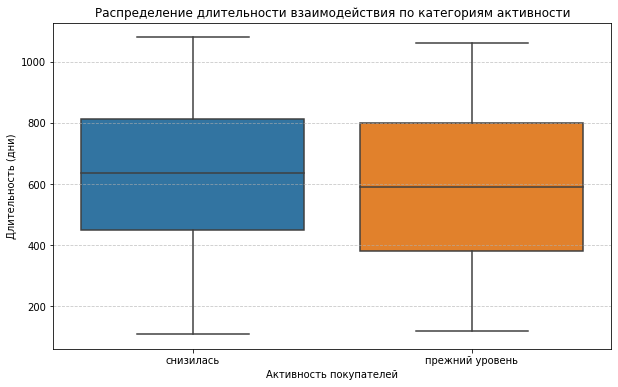

In [33]:
# График распределения duration по группам buying_activity
plt.figure(figsize=(10, 6))
sns.boxplot(x='buying_activity', y='duration', data=market_file_df)
plt.title('Распределение длительности взаимодействия по категориям активности')
plt.xlabel('Активность покупателей')
plt.ylabel('Длительность (дни)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- Диапазоны длительности взаимодействия для обеих групп схожи, минимальные и максимальные значения практически совпадают.
- Медианы расположены примерно на уровне 600 дней для обеих групп, что подтверждает отсутствие значительной разницы.
- У группы со **сниженной активностью** значение первого квартиля (Q1) немного выше, чем у группы с **прежним уровнем активности**.
- На основе графика можно сделать предварительный вывод, что длительность взаимодействия, скорее всего, не оказывает заметного влияния на снижение покупательской активности.

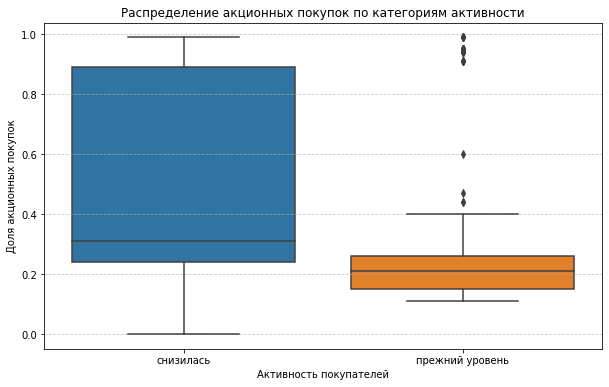

In [34]:
# График распределения promo_purchases по группам buying_activity
plt.figure(figsize=(10, 6))
sns.boxplot(x='buying_activity', y='promo_purchases', data=market_file_df)
plt.title('Распределение акционных покупок по категориям активности')
plt.xlabel('Активность покупателей')
plt.ylabel('Доля акционных покупок')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- **Группа со сниженной покупательской активностью** приобретает товары по акциям заметно чаще, чем группа с прежним уровнем активности.
- В группе с **прежним уровнем активности** присутствуют выбросы, что свидетельствует о наличии пользователей, которые активно пользуются акционными предложениями, несмотря на общий тренд.
- Медианное значение для группы со сниженной активностью составляет **0.3**, что выше медианы группы с прежним уровнем активности (**0.2**).
- Такая разница в распределении может свидетельствовать, что пользователи со сниженной активностью чаще являются ситуативными покупателями, интересующимися преимущественно акциями, а не регулярными предложениями магазина.

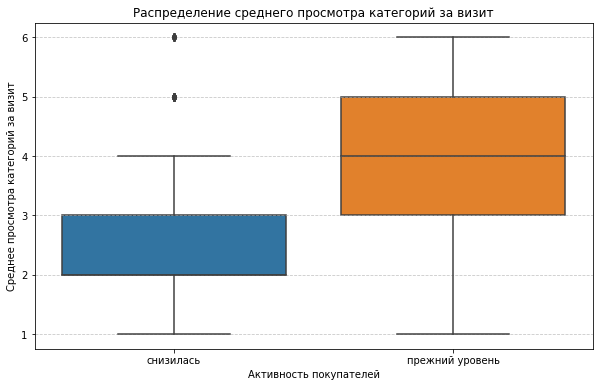

In [35]:
# График распределения session_cat_avg по группам buying_activity
plt.figure(figsize=(10, 6))
sns.boxplot(x='buying_activity', y='session_cat_avg', data=market_file_df)
plt.title('Распределение среднего просмотра категорий за визит')
plt.xlabel('Активность покупателей')
plt.ylabel('Среднее просмотра категорий за визит')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- Среднее количество просмотренных категорий за визит значительно отличается между группами.
- **Группа со сниженной активностью** в среднем просматривает меньше категорий: диапазон значений лежит между первым (Q1 = 2) и третьим квартилями (Q3 = 2), что свидетельствует о крайне низкой вариативности.
- **Группа с прежним уровнем активности** демонстрирует значительно более широкий диапазон: медиана составляет ~4 категории, а Q3 достигает ~5, что говорит о большей вовлечённости этих пользователей.
- Данные могут свидетельствовать о том, что просмотр большего числа категорий коррелирулибо, непосредственно, ст с поддержанием покупательск (сниженная активность = меньшее количество просмотренных категорий), либо с активностью в разрезе акционных покупок (пользователи, которые хотят воспользоваться акцией не просматривают другие категории)сти.

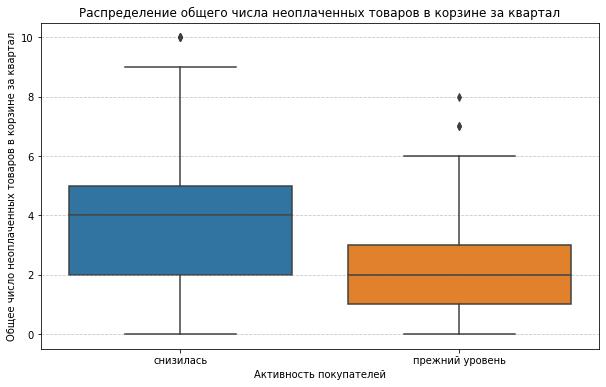

In [36]:
# График распределения card_items_quorter_avg по группам buying_activity
plt.figure(figsize=(10, 6))
sns.boxplot(x='buying_activity', y='card_items_quorter_avg', data=market_file_df)
plt.title('Распределение общего числа неоплаченных товаров в корзине за квартал')
plt.xlabel('Активность покупателей')
plt.ylabel('Общее число неоплаченных товаров в корзине за квартал')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- У пользователей с **прежним уровнем активности** количество неоплаченных товаров в корзине за квартал примерно в два раза меньше, чем у пользователей со **сниженной активностью**.
- Медианное значение для группы со сниженной активностью составляет **4**, тогда как для группы с прежней активностью — **2**.
- В группе с прежним уровнем активности наблюдаются выбросы, что указывает на наличие отдельных пользователей, оставляющих значительное количество товаров в корзине.
- Повышенное количество неоплаченных товаров в корзине у пользователей со сниженной активностью может свидетельствовать о затруднениях или нерешительности при завершении покупок.

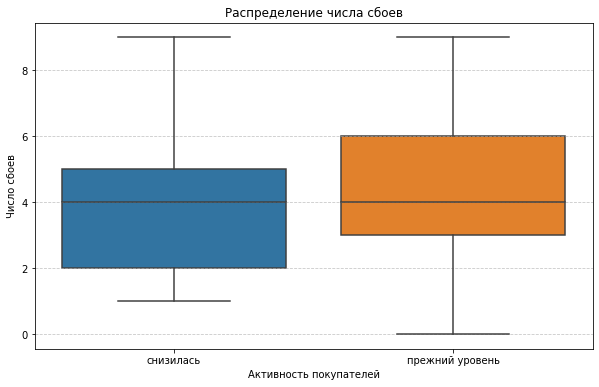

In [37]:
# График распределения downtime_count по группам buying_activity
plt.figure(figsize=(10, 6))
sns.boxplot(x='buying_activity', y='downtime_count', data=market_file_df)
plt.title('Распределение числа сбоев')
plt.xlabel('Активность покупателей')
plt.ylabel('Число сбоев')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- Медианы числа сбоев для обеих групп равны **4**, что свидетельствует об одинаковом уровне доступности системы для пользователей.
- **Группа с прежним уровнем активности** имеет более широкий диапазон значений, что может быть связано с их более частым использованием сервиса и, как следствие, большей вероятностью столкнуться со сбоями.
- На основе графика можно предположить, что покупательская активность, скорее всего, **не зависит** от количества сбоев системы.

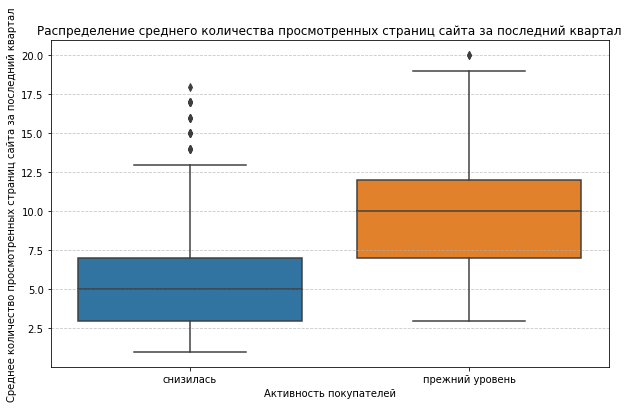

In [38]:
# График распределения session_pages_avg по группам buying_activity
plt.figure(figsize=(10, 6))
sns.boxplot(x='buying_activity', y='session_pages_avg', data=market_file_df)
plt.title('Распределение среднего количества просмотренных страниц сайта за последний квартал')
plt.xlabel('Активность покупателей')
plt.ylabel('Среднее количество просмотренных страниц сайта за последний квартал')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- Пользователи со **сниженной активностью** просматривали значительно меньше страниц за последний квартал, что логично, учитывая их снижение активности.
- **Медианное значение** для пользователей с прежней активностью составляет **10 страниц**, тогда как для пользователей со сниженной активностью — **5 страниц**.
- Группа с прежней активностью демонстрирует более широкий диапазон значений, включая выбросы, что указывает на высокую вариативность их вовлечённости.
- На основе графика сложно однозначно определить причинно-следственную связь: уменьшение количества просмотренных страниц может быть как следствием, так и предвестником снижения активности.

#### Распределение данных датасета `market_money_df`

In [39]:
# Получим статистические характеристики для переменной revenue датасета market_money_df
market_money_df['revenue'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64

- Минимальное значение равно 0
- Значение 25-го процентиля равно 4590 руб, что значительно превышает минимум
- Максимальное значение в 20 раз превышает значение 75-го процентиля.

Посмтрои диаграмму box-plot для выявления выбросов.

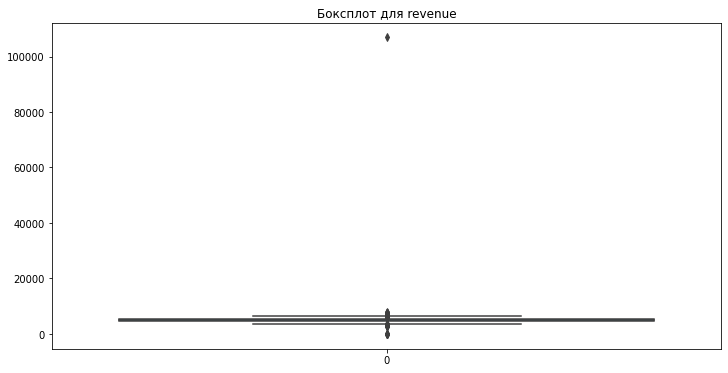

In [40]:
# Построение боксплота для выявления выбросов по выручке
plt.figure(figsize=(12, 6))
sns.boxplot(data=market_money_df['revenue'])
plt.title("Боксплот для revenue")
plt.show()

Box-plot показывает явный выброс на уровне значения `100 000` и некоторое количество значений, сконцентрированное в районе 0. Так как все значения в датасете имеют значение в рамках `10 000`, такие сильные выбросы могут негативно повлиять на дальнейшее моделирование. Избавимся от выбросов ограничив диапазон значений в датасете до `10 000` руб. С выбросами около 0 ничего делать не будем, т.к. это значит, что пользователь не совершал покупок за период.

In [41]:
# Ограничим значения выручки до 10000 руб
market_money_df = market_money_df[market_money_df['revenue'] < 10000]

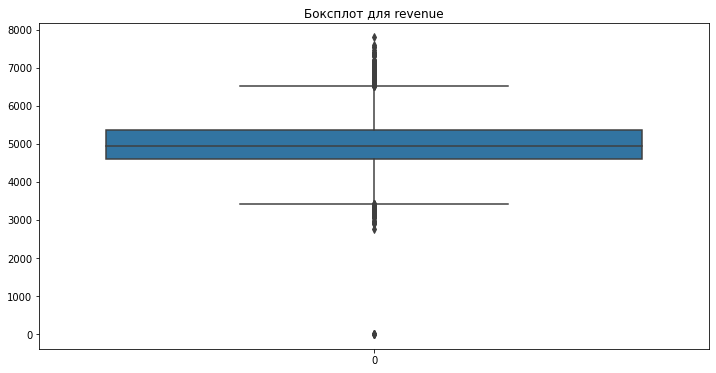

In [42]:
# Проверим результат
plt.figure(figsize=(12, 6))
sns.boxplot(data=market_money_df['revenue'])
plt.title("Боксплот для revenue")
plt.show()

После удаления критических выбросов можем наблюдать более компактное распределение значений. Несмотря на наличие множество точек за пределами усов графика (выбросов), оставим данные в таком виде, так как представленный диапазон является наиболее репрезентативным для дальнейшей работы.

In [43]:
# Получим статистические характеристики для переменной mins датасета market_time_df
market_time_df['mins'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: mins, dtype: float64

Данные выглядят нормально распределенными и не содержат выбросов

In [44]:
# Получим статистические характеристики для переменной income датасета money_df
money_df['income'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: income, dtype: float64

Данные также выглядят нормально распределенными и не содержат выбросов. Сформулируем промежуточные выводы и перейдем к анализу категориальных значений

#### Промежуточные выводы

- **Маркетинговые коммуникации:** Более высокое среднее и медиана наблюдаются у группы с прежним уровнем активности, что может свидетельствовать о положительном влиянии коммуникаций на удержание покупателей.
- **Просмотр категорий и страниц:** Группы с прежней активностью просматривают больше категорий и страниц, что указывает на их более высокую вовлечённость.
- **Акционные покупки:** Пользователи со сниженной активностью чаще участвуют в акциях, что может говорить о ситуативном характере их покупок.
- **Неоплаченные товары:** У группы со сниженной активностью в корзинах больше неоплаченных товаров, что может указывать на нерешительность при совершении покупок.
- **Сбои системы:** Число сбоев схоже в обеих группах и, вероятно, не оказывает влияния на покупательскую активность.

Распределения показывают, что снижение активности сопровождается меньшей вовлечённостью и нерегулярным поведением, в то время как высокая активность поддерживается через широкий просмотр ассортимента и маркетинговые коммуникации.

### Анализ категориальных данных

В рамках анализа категориальных значений построим распределение категорий в разрезе групп целевого признака. Это поможет понять, какие категории более характерны для активных или менее активных пользователей.

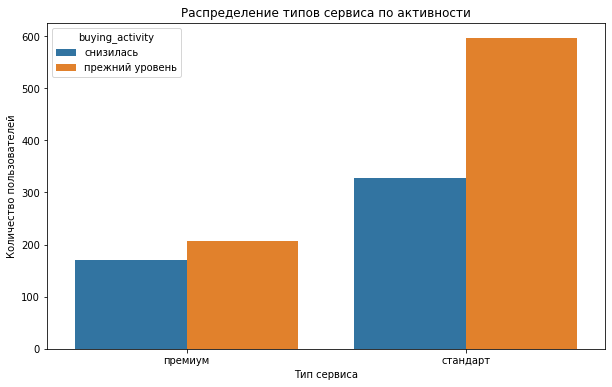

In [45]:
# Диаграмма распределения типов сервиса по активности пользователей
plt.figure(figsize=(10, 6))
sns.countplot(x='service_type', hue='buying_activity', data=market_file_df)
plt.title("Распределение типов сервиса по активности")
plt.xlabel('Тип сервиса')
plt.ylabel('Количество пользователей')
plt.show()

- **Премиум-подписка:**
    - У значительной доли пользователей с премиум-подпиской (~50%) наблюдается снижение активности.
    - Разница между уровнями активности (сниженная и прежняя) минимальна, что может указывать на риск потери части премиум-аудитории.
- **Стандартная подписка:**
    - Среди пользователей со стандартной подпиской снижение активности встречается вдвое реже.
    - Большинство пользователей стандартной подписки сохраняют прежний уровень активности, что говорит о более стабильной вовлечённости этой группы.

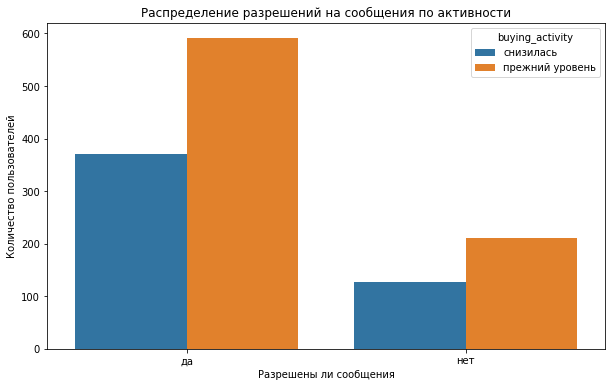

In [46]:
# Диаграмма распределения разрешений на сообщения по активности пользователей
plt.figure(figsize=(10, 6))
sns.countplot(x='messages_allowed', hue='buying_activity', data=market_file_df)
plt.title("Распределение разрешений на сообщения по активности")
plt.xlabel('Разрешены ли сообщения')
plt.ylabel('Количество пользователей')
plt.show()

- **Разрешено отправлять сообщения:**
    - Доля пользователей со сниженной активностью составляет около **60%** относительно пользователей, сохранивших прежний уровень активности.
- **Сообщения запрещены:**
    - Аналогичная картина: доля пользователей со сниженной активностью также составляет около **60%** относительно пользователей с прежним уровнем активности.

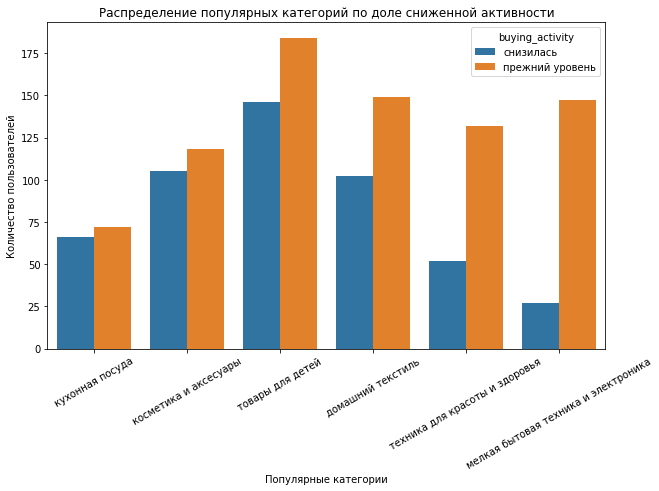

In [47]:
# Вычисление доли сниженной активности для каждой категории
category_ratios = (
    market_file_df
    .pivot_table(index='favourite_cat', columns='buying_activity', aggfunc='size', fill_value=0)
    .assign(ratio=lambda x: x['снизилась'] / (x['прежний уровень'] + x['снизилась']))
    .sort_values(by='ratio', ascending=False)
)

# Получение порядка категорий
sorted_categories = category_ratios.index

# Диаграмма распределения популярных категорий по активности пользователей
plt.figure(figsize=(10, 6))
sns.countplot(
    x='favourite_cat',
    hue='buying_activity',
    data=market_file_df,
    order=sorted_categories
)
plt.title("Распределение популярных категорий по доле сниженной активности")
plt.xlabel('Популярные категории')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=30)
plt.show()


- **Самая высокая доля сниженной активности** наблюдается в категориях **"кухонная посуда"**, **"косметика и аксессуары"** и **"товары для детей"**.
- В категории **"товары для детей"** также фиксируется **наибольшее количество пользователей** среди всех категорий, включая тех, кто снизил активность.
- Категория **"товары для детей"** выделяется как важный сегмент, который необходимо сохранить и стимулировать, так как здесь сосредоточена значительная часть пользователей с высоким риском потери активности.

**Промежуточные выводы**

- **Тип сервиса:** Премиум-пользователи демонстрируют больший риск снижения активности (около 50%), тогда как среди стандартных пользователей снижение активности встречается реже.
- **Разрешение на сообщения:** Доля снижения активности одинакова (~60%) вне зависимости от того, разрешены или запрещены сообщения.
- **Популярные категории:** Категория "товары для детей" — ключевая: здесь сосредоточено наибольшее число пользователей, включая тех, кто снизил активность. Высокая доля сниженной активности также характерна для категорий "кухонная посуда" и "косметика и аксессуары".

Категории товаров и тип сервиса имеют большее влияние на снижение активности, чем разрешения на сообщения. Особое внимание следует уделить удержанию пользователей в премиум-сегменте и в категориях "товары для детей" и "кухонная посуда".

### Объединение таблиц

Для более глубокого анализа объединим данные по трем таблицам `market_file`, `market_money` и `market_time`. 

In [48]:
# Объединяем market_file_df с market_money_df
merged_full_df = market_file_df.merge(market_money_df, on='id', how='left')

# Добавляем данные из market_time_df
merged_full_df = merged_full_df.merge(market_time_df, on=['id', 'period'], how='left')

# Преобразование: создание отдельных столбцов для каждого периода (revenue и mins)
final_pivoted_df = merged_full_df.pivot_table(
    index=['id', 'buying_activity', 'service_type'],
    columns='period',
    values=['revenue', 'mins'],
    aggfunc='first'
).reset_index()

# Приведение названий столбцов к читаемому формату
final_pivoted_df.columns = ['_'.join(col).strip('_') for col in final_pivoted_df.columns]

# Восстановление остальных данных из market_file_df, чтобы сохранить все оригинальные колонки
final_merged_df = pd.merge(
    market_file_df, 
    final_pivoted_df, 
    on=['id', 'buying_activity', 'service_type'],
    how='left'
)

In [49]:
# Взглянем на первые строки нового датасета
final_merged_df.head()

,id,buying_activity,service_type,messages_allowed,marketing_6_mon_avg,marketing_curr_mon,duration,promo_purchases,favourite_cat,session_cat_avg,card_items_quorter_avg,downtime_count,session_pages_avg,mins_предыдущий_месяц,mins_текущий_месяц,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,13.0,14.0,0.0,0.0,3293.1
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,12.0,10.0,5216.0,4472.0,4971.6
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,8.0,13.0,5457.5,4826.0,5058.4
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,11.0,13.0,6158.0,4793.0,6610.4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,8.0,11.0,5807.5,4594.0,5872.5


In [50]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   buying_activity              1300 non-null   object 
 2   service_type                 1300 non-null   object 
 3   messages_allowed             1300 non-null   object 
 4   marketing_6_mon_avg          1300 non-null   float64
 5   marketing_curr_mon           1300 non-null   int64  
 6   duration                     1300 non-null   int64  
 7   promo_purchases              1300 non-null   float64
 8   favourite_cat                1300 non-null   object 
 9   session_cat_avg              1300 non-null   int64  
 10  card_items_quorter_avg       1300 non-null   int64  
 11  downtime_count               1300 non-null   int64  
 12  session_pages_avg            1300 non-null   int64  
 13  mins_предыдущий_ме

Очистим данные от неактивных пользователей - те, у которых есть нулевая выручка хотя бы в одном периоде. Для этого оставим в датасете только тех пользователей, у которых значения всех трех периодов не равны нулю и не равны пустому значению.

In [51]:
final_merged_df = final_merged_df[
    ((final_merged_df['revenue_препредыдущий_месяц'] != 0) & (~final_merged_df['revenue_препредыдущий_месяц'].isna())) &
    ((final_merged_df['revenue_предыдущий_месяц'] != 0) & (~final_merged_df['revenue_предыдущий_месяц'].isna())) &
    ((final_merged_df['revenue_текущий_месяц'] != 0) & (~final_merged_df['revenue_текущий_месяц'].isna()))
]

In [52]:
# Проверим результат вызвав метод info для обновленного датасета
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1296 non-null   int64  
 1   buying_activity              1296 non-null   object 
 2   service_type                 1296 non-null   object 
 3   messages_allowed             1296 non-null   object 
 4   marketing_6_mon_avg          1296 non-null   float64
 5   marketing_curr_mon           1296 non-null   int64  
 6   duration                     1296 non-null   int64  
 7   promo_purchases              1296 non-null   float64
 8   favourite_cat                1296 non-null   object 
 9   session_cat_avg              1296 non-null   int64  
 10  card_items_quorter_avg       1296 non-null   int64  
 11  downtime_count               1296 non-null   int64  
 12  session_pages_avg            1296 non-null   int64  
 13  mins_предыдущий_ме

Записи о четырех неактивных пользователях были удалены.

#### Анализ активности по периодам
- Построим график суммарной выручки за каждый из трёх периодов, чтобы увидеть общую картину.
- Построим график распределение выручки между группами активности (buying_activity).

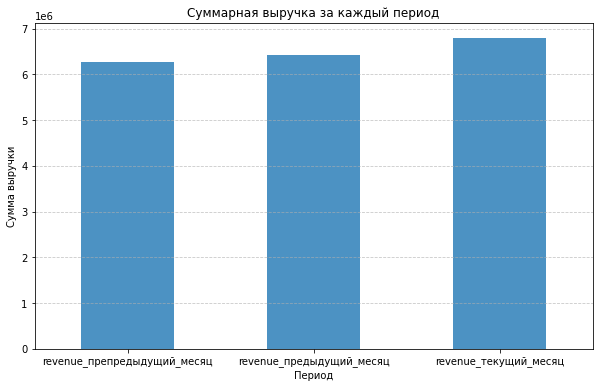

In [53]:
# Суммарная выручка за каждый период
total_revenue_by_period = final_merged_df[
    ['revenue_препредыдущий_месяц', 'revenue_предыдущий_месяц', 'revenue_текущий_месяц']
].sum()

# Построение графика суммарной выручки
plt.figure(figsize=(10, 6))
total_revenue_by_period.plot(kind='bar', alpha=0.8)
plt.title('Суммарная выручка за каждый период')
plt.xlabel('Период')
plt.ylabel('Сумма выручки')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- За последние три месяца наблюдается рост выручки, которая в текущем месяце достигла максимального значения за рассматриваемый квартал.

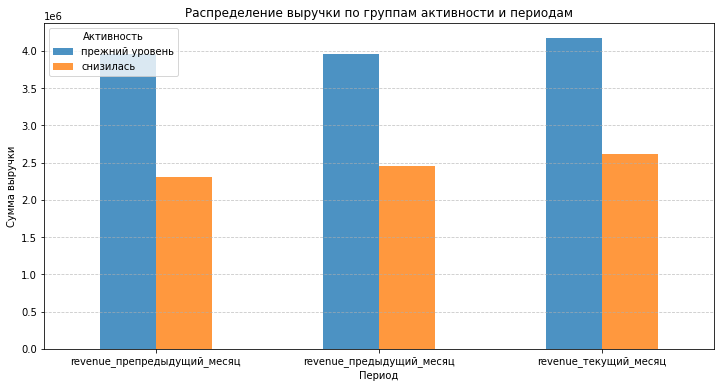

In [54]:
# Суммарная выручка в разрезе групп активности
revenue_by_activity = final_merged_df.groupby('buying_activity')[
    ['revenue_препредыдущий_месяц', 'revenue_предыдущий_месяц', 'revenue_текущий_месяц']
].sum()

# Построение графика распределения выручки по группам активности
revenue_by_activity.T.plot(kind='bar', figsize=(12, 6), alpha=0.8)
plt.title('Распределение выручки по группам активности и периодам')
plt.xlabel('Период')
plt.ylabel('Сумма выручки')
plt.xticks(rotation=0)
plt.legend(title='Активность', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- Несмотря на общий рост выручки за последние три месяца, также наблюдается увеличение доли пользователей со сниженной активностью.

#### Исследование динамики

- **Динамика выручки:**
    - Рассчитаем разницу выручки между периодами для каждого пользователя со сниженной активностью.
    - Определим пользователей с самой большой отрицательной динамикой и проанализируем их поведение.
- **Динамика времени:**
    - Сделаем аналогичный расчёт для времени на сайте, чтобы выявить пользователей, которые стали тратить на сайт меньше времени.

In [55]:
# Создаем новые столбцы для динамики выручки
activity_groups_df = final_merged_df.copy()
activity_groups_df['revenue_change_current_previous'] = (
    activity_groups_df['revenue_текущий_месяц'] - activity_groups_df['revenue_предыдущий_месяц']
)
activity_groups_df['revenue_change_previous_preprevious'] = (
    activity_groups_df['revenue_предыдущий_месяц'] - activity_groups_df['revenue_препредыдущий_месяц']
)

# Создаем новые столбцы для динамики времени
activity_groups_df['time_change_current_previous'] = (
    activity_groups_df['mins_текущий_месяц'] - activity_groups_df['mins_предыдущий_месяц']
)

In [56]:
# Определим пользователей с наибольшим падением выручки
negative_revenue_change = activity_groups_df[
    (activity_groups_df['revenue_change_current_previous'] < 0) |
    (activity_groups_df['revenue_change_previous_preprevious'] < 0)
]
negative_revenue_change.sort_values(by=['revenue_change_current_previous', 'revenue_change_previous_preprevious']).head()

,id,buying_activity,service_type,messages_allowed,marketing_6_mon_avg,marketing_curr_mon,duration,promo_purchases,favourite_cat,session_cat_avg,...,downtime_count,session_pages_avg,mins_предыдущий_месяц,mins_текущий_месяц,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц,revenue_change_current_previous,revenue_change_previous_preprevious,time_change_current_previous
13,215361,снизилась,стандарт,да,5.1,4,199,0.23,техника для красоты и здоровья,4,...,2,3,11.0,13.0,6400.0,4597.0,3789.7,-2610.3,1803.0,2.0
895,216243,прежний уровень,стандарт,да,3.3,5,812,0.11,косметика и аксесуары,4,...,8,5,12.0,19.0,4438.0,5485.0,3660.6,-777.4,-1047.0,7.0
667,216015,прежний уровень,стандарт,да,5.4,3,629,0.21,домашний текстиль,6,...,6,6,15.0,19.0,4466.0,5492.0,3706.8,-759.2,-1026.0,4.0
1057,216405,прежний уровень,стандарт,да,4.0,4,436,0.21,мелкая бытовая техника и электроника,4,...,6,9,17.0,21.0,4637.0,5663.0,3877.8,-759.2,-1026.0,4.0
970,216318,прежний уровень,премиум,да,3.9,5,1040,0.30,косметика и аксесуары,2,...,5,14,21.0,16.0,4108.5,5118.0,3363.6,-744.9,-1009.5,-5.0


In [57]:
# Определим пользователей с наибольшим падением времени
negative_time_change = activity_groups_df[activity_groups_df['time_change_current_previous'] < 0]
negative_time_change.sort_values(by='time_change_current_previous').head()

,id,buying_activity,service_type,messages_allowed,marketing_6_mon_avg,marketing_curr_mon,duration,promo_purchases,favourite_cat,session_cat_avg,...,downtime_count,session_pages_avg,mins_предыдущий_месяц,mins_текущий_месяц,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц,revenue_change_current_previous,revenue_change_previous_preprevious,time_change_current_previous
1007,216355,прежний уровень,стандарт,да,5.1,4,433,0.14,товары для детей,4,...,4,9,20.0,5.0,4005.0,4768.0,4796.7,791.7,-763.0,-15.0
1095,216443,прежний уровень,стандарт,нет,4.8,4,322,0.17,домашний текстиль,2,...,6,6,21.0,6.0,5140.0,5029.0,5366.2,226.2,111.0,-15.0
1285,216633,прежний уровень,стандарт,нет,2.4,4,192,0.35,техника для красоты и здоровья,3,...,6,10,20.0,6.0,5311.0,4651.0,6013.0,702.0,660.0,-14.0
510,215858,прежний уровень,стандарт,да,5.5,4,510,0.15,мелкая бытовая техника и электроника,2,...,7,16,20.0,6.0,5170.5,4347.0,6014.2,843.7,823.5,-14.0
507,215855,прежний уровень,стандарт,да,5.5,5,149,0.20,кухонная посуда,3,...,6,6,21.0,8.0,5634.5,4682.0,6590.0,955.5,952.5,-13.0


<Figure size 720x432 with 0 Axes>

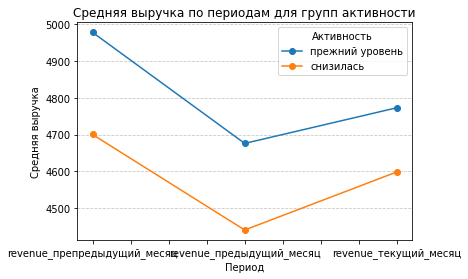

In [58]:
# Группировка и расчет средних значений для графика
average_revenue_negative = negative_revenue_change.groupby('buying_activity')[
    ['revenue_препредыдущий_месяц', 'revenue_предыдущий_месяц', 'revenue_текущий_месяц']
].mean()

# Построение графика
plt.figure(figsize=(10, 6))
average_revenue_negative.T.plot(marker='o')
plt.title('Средняя выручка по периодам для групп активности')
plt.xlabel('Период')
plt.ylabel('Средняя выручка')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Активность')
plt.xticks(rotation=0)
plt.show()

- **Схожая динамика изменений:**
    - Независимо от активности, у обеих групп наблюдается "U"-образная динамика: выручка падает к середине периода, а затем немного восстанавливается.
    - Это может быть связано с общими сезонными или маркетинговыми эффектами, которые одинаково влияют на всех пользователей.
- **Низкий уровень выручки в группе со сниженной активностью:**
    - Хотя динамика схожа, базовый уровень выручки в группе со сниженной активностью значительно ниже. Это подтверждает, что такие пользователи в принципе менее активны, даже если следуют общей тенденции.
- **Дополнительный вывод:**
    - Возможно, пользователи из группы "сниженная активность" просто изначально были менее вовлечёнными или их активность снижалась уже давно, но это не связано с текущей динамикой.

<Figure size 720x432 with 0 Axes>

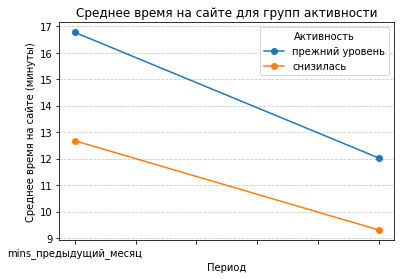

In [59]:
# Рассчитаем средние значения времени для пользователей с падением
average_time_negative = negative_time_change.groupby('buying_activity')[
    ['mins_предыдущий_месяц', 'mins_текущий_месяц']
].mean()


# Построение графика
plt.figure(figsize=(10, 6))
average_time_negative.T.plot(marker='o')
plt.title('Среднее время на сайте для групп активности')
plt.xlabel('Период')
plt.ylabel('Среднее время на сайте (минуты)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Активность')
plt.xticks(rotation=0)
plt.show()

1. **Снижение времени для обеих групп:**
    - Время, проведённое на сайте, снижается для обеих групп по мере перехода от предыдущего к текущему месяцу.
    - Это может говорить о снижении интереса к платформе или отсутствии вовлекающих стимулов.
2. **Группа со сниженной активностью:**
    - У этой группы время на сайте изначально ниже, что подтверждает её менее вовлечённое поведение.
3. **Схожая динамика:**
    - Графики для обеих групп практически параллельны, что может означать, что снижение времени на сайте вызвано глобальными факторами (например, сезонностью), а не специфическими проблемами только одной группы.

### Промежуточные выводы

- **Числовые признаки:**
    - Маркетинговые коммуникации положительно коррелируют с активностью покупателей: группа с прежним уровнем активности демонстрирует более высокие средние и медианные значения.
    - Количество просмотренных категорий и страниц выше у активных пользователей, что свидетельствует о большей вовлечённости.
    - Пользователи со сниженной активностью чаще совершают акционные покупки, что говорит о ситуативном характере их покупок.
    - У группы со сниженной активностью больше неоплаченных товаров в корзинах, что может свидетельствовать о нерешительности при завершении покупок.
    - Длительность взаимодействия и количество системных сбоев не имеют значительного влияния на покупательскую активность.
- **Категориальные признаки:**
    - Премиум-пользователи демонстрируют больший риск снижения активности (около 50%), в то время как стандартные пользователи более стабильны.
    - Категория "товары для детей" выделяется как ключевая с точки зрения вовлечённости, но также имеет наибольшую долю пользователей со сниженной активностью.
    - Высокая доля сниженной активности также характерна для категорий "кухонная посуда" и "косметика и аксессуары".
- **Динамика активности:**
    - За последние три месяца наблюдается рост выручки, которая в текущем месяце достигла максимального значения за квартал.
    - Несмотря на общий рост выручки, доля пользователей со сниженной активностью также увеличивается.
    - Схожая "U"-образная динамика выручки для всех групп может быть связана с сезонными или маркетинговыми эффектами.
- **Временные данные:**
    - Время, проведённое на сайте, снижается у обеих групп, что может быть вызвано общими глобальными факторами, а не специфическими проблемами одной группы.
- **Общие выводы:**
    - Снижение активности связано с меньшей вовлечённостью пользователей, меньшим количеством просмотренных страниц и категорий, а также акцентом на акционные предложения.
    - Премиум-пользователи и категория "товары для детей" требуют особого внимания для удержания, так как они демонстрируют высокий риск снижения активности.
 
Перейдем к корреляционному анализу данных

## Корреляционный анализ

### Проверка на мультиколлинеарность

Для подробной проверки на мультиколлинеарность, воспользуемся средствами библиотеки `phik`

In [60]:
#Удалим колонку id, т.к. эти данные не несут никакой смысловой нагрузки в рамках данного анализа
final_merged_df = final_merged_df.drop(columns=['id'], axis=1)

# Получим список всех колонок объединенной таблицы
final_merged_df.columns

Index(['buying_activity', 'service_type', 'messages_allowed',
       'marketing_6_mon_avg', 'marketing_curr_mon', 'duration',
       'promo_purchases', 'favourite_cat', 'session_cat_avg',
       'card_items_quorter_avg', 'downtime_count', 'session_pages_avg',
       'mins_предыдущий_месяц', 'mins_текущий_месяц',
       'revenue_предыдущий_месяц', 'revenue_препредыдущий_месяц',
       'revenue_текущий_месяц'],
      dtype='object')

In [61]:
# Перечислим в списке непрерывные числовые переменные для указания их в параметре interval_cols
numeric_features = ['marketing_6_mon_avg', 'duration', 'promo_purchases',
                    'revenue_предыдущий_месяц', 'revenue_препредыдущий_месяц',
                    'revenue_текущий_месяц']

# Расчёт корреляционной матрицы с phik
correlation_matrix = final_merged_df.phik_matrix(interval_cols=numeric_features)

# Вывод корреляционной матрицы
correlation_matrix

,buying_activity,service_type,messages_allowed,marketing_6_mon_avg,marketing_curr_mon,duration,promo_purchases,favourite_cat,session_cat_avg,card_items_quorter_avg,downtime_count,session_pages_avg,mins_предыдущий_месяц,mins_текущий_месяц,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц
buying_activity,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.405041,0.224154,0.747331,0.604355,0.569983,0.224638,0.497393,0.197213
service_type,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.113015,0.079515,0.087776,0.121210,0.061764,0.000000,0.069704,0.124216
messages_allowed,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.162524,0.021839,0.097094,0.063528,0.000000,0.080842,0.000000,0.060907
marketing_6_mon_avg,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.217731,0.142401,0.376035,0.322830,0.331480,0.155476,0.315331,0.039795
marketing_curr_mon,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.142887,0.116946,0.000000,0.166871,0.079883,0.051824,0.000000,0.000000
duration,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.128222,0.175608,0.128089,0.046299,0.021117,0.125572,0.113200,0.147048
promo_purchases,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.246665,0.000000,0.350714,0.314140,0.287292,0.060733,0.226381,0.071094
favourite_cat,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.254746,0.000000,0.177637,0.218727,0.113774,0.252097,0.043528,0.237240
session_cat_avg,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.334927,0.070315,0.293781,0.219174,0.236298,0.098440,0.176828,0.092597
card_items_quorter_avg,0.405041,0.113015,0.162524,0.217731,0.142887,0.128222,0.246665,0.254746,0.334927,1.000000,0.000000,0.310843,0.194298,0.158243,0.193536,0.189320,0.166017


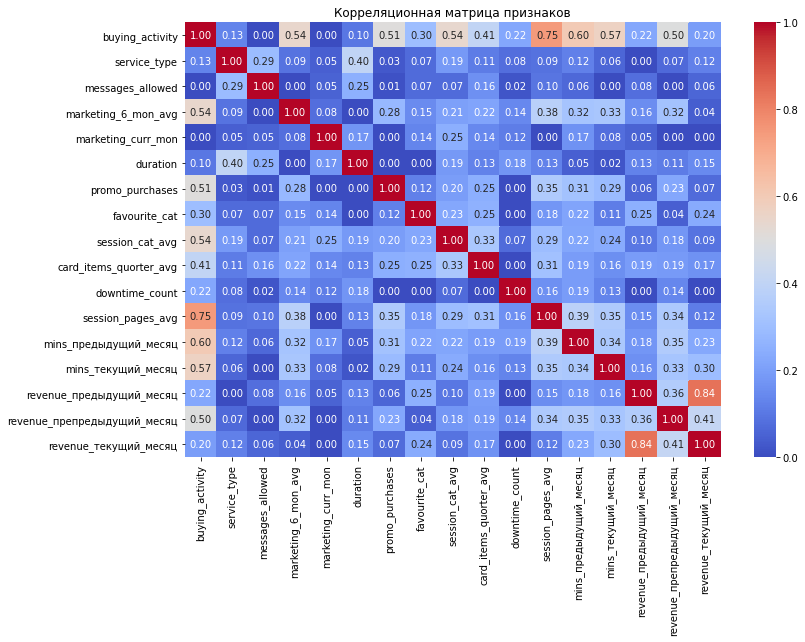

In [62]:
# Визуализация тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Корреляционная матрица признаков')
plt.show()

1. **Сильные корреляции (>0.8):**
    - **`revenue_предыдущий_месяц` и `revenue_текущий_месяц` (0.84):**
3. **Средние корреляции (0.4–0.8):**
    - **`buying_activity` и `session_pages_avg` (0.75):**
    - **`buying_activity` и `mins_предыдущий_месяц` (0.6):**
    - **`buying_activity` и `mins_текущий_месяц` (0.57):**
    - **`buying_activity` и `marketing_6_mon_avg` (0.54):**
    - **`buying_activity` и `session_cat_avg` (0.54):**
    - **`buying_activity` и `promo_purchases` (0.51):**
    - **`buying_activity` и `revenue_предыдущий_месяц` (0.54):**
    - **`buying_activity` и `card_item_quorter_avg` (0.41):**
4. **Слабые корреляции (<0.4):**
    - Большинство признаков, например, `marketing_curr_mon` и `downtime_count`, слабо связаны с другими признаками, что снижает риск мультиколлинеарности.

В данных присуисивует относительно сильная корреляция признаков `revenue_предыдущий_месяц` и `revenue_текущий_месяц` (0.84). Уровень корреляции не критичен для удаления признаков. Учтем это при моделировании используя регуляцию

## Использование пайплайнов

### Подготовка данных

Разделим данные на тренировочные и тестовые, используя стратификацию

In [63]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# делим данные на входные и целевые
X = final_merged_df.drop(['buying_activity'], axis=1)
y = final_merged_df['buying_activity']

# Разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

Создадим списки с названиями признаков, разделив их по типу кодировщика/скейлера.
- для имеющихся категориальных переменных порядок категорий не имеет значения, применим ко всем OneHotEncoder
- для количественных переменных с распределением близким к нормальному применим StandardScaler
- для оставшихся количественных переменных применим MinMaxScaler

In [64]:
# Cоздадим списки с названиями признаков
ohe_columns = ['favourite_cat']

ord_columns = ['service_type', 'messages_allowed']

num_columns = ['marketing_6_mon_avg', 'marketing_curr_mon', 'duration',
               'promo_purchases', 'session_cat_avg',
               'card_items_quorter_avg', 'downtime_count', 'session_pages_avg',
               'mins_предыдущий_месяц', 'mins_текущий_месяц',
               'revenue_препредыдущий_месяц', 'revenue_предыдущий_месяц', 'revenue_текущий_месяц']

### Создание пайплайна с использованием `ColumnTransformer`

Для кодирования данных создадим первый пайплайн используя `ColumnTransformer`

In [65]:
# Создание пайплайна для OneHotEncoder
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [66]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['нет', 'да']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [67]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

### Создание пайплайна для поиска лучшей модели

In [68]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

### Подбор гиперпараметров

Для поиска гиперпараметров используем RandomizedSearchCV. Для оценки качества модели используем метрику `f1_weighted` учитывая наличие дисбаланса классов

In [69]:
# Инициализация RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid, 
    scoring='f1_weighted', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Поиск лучших параметров
randomized_search.fit(X_train, y_train)

print("Лучшие параметры:", randomized_search.best_params_)
print("Метрика f1 для лучшей модели кросс-валидации:", randomized_search.best_score_)

Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models': SVC(probability=True, random_state=42)}
Метрика f1 для лучшей модели кросс-валидации: 0.8810260867721877


Лучшей моделью по итогу работы RandomizedSearchCV стала модель `SVC` с использованием `StandardScaler`. Значение метрики `f1_weighted` равно 0.88

### Выбор метрик

По результату работы randomized_search построим таблицу параметров и значений метрик для лучших моделей.

In [70]:
result = pd.DataFrame(randomized_search.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
9,1,"SVC(probability=True, random_state=42)",0.881026,"{'preprocessor__num': StandardScaler(), 'model..."
0,2,"SVC(probability=True, random_state=42)",0.869317,"{'preprocessor__num': MinMaxScaler(), 'models'..."
3,3,"LogisticRegression(penalty='l1', random_state=...",0.858914,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,4,KNeighborsClassifier(),0.857257,"{'preprocessor__num': StandardScaler(), 'model..."
1,5,"LogisticRegression(penalty='l1', random_state=...",0.854005,"{'preprocessor__num': StandardScaler(), 'model..."
8,6,DecisionTreeClassifier(random_state=42),0.826555,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,7,DecisionTreeClassifier(random_state=42),0.784704,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,8,DecisionTreeClassifier(random_state=42),0.720826,"{'preprocessor__num': 'passthrough', 'models__..."
7,9,DecisionTreeClassifier(random_state=42),0.701669,"{'preprocessor__num': StandardScaler(), 'model..."
2,10,DecisionTreeClassifier(random_state=42),0.572240,"{'preprocessor__num': StandardScaler(), 'model..."


In [71]:
# Рассчитаем качество модели на тестовой выборке
y_test_pred = randomized_search.predict(X_test)
print(f"Метрика F1 на тестовой выборке: {f1_score(y_test, y_test_pred, average='weighted')}")

Метрика F1 на тестовой выборке: 0.9055045273012812


На тестовой выборке модель показала себя лучше, чем на тренировочной.

Для того чтобы убедиться в адекватности модели, сравним модель с `DummyClassifier`. Если модель не превосходит `DummyClassifier`, то она неэффективна и поиск подходящей модели придется начать сначала. Используем для 

In [72]:
# Инициализация и обучение DummyClassifier
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# Применение DummyClassifier к тестовым данным
dummy_model_preds = dummy_model.predict(X_test)
dummy_model_probas = dummy_model.predict_proba(X_test)[:,1]

# Расчет и вывод метрики f1
dummy_f1 = f1_score(y_test, dummy_model_preds, average='weighted')
print(f"Метрика F1 на тестовой выборке для DummyClassifier: {dummy_f1}")

Метрика F1 на тестовой выборке для DummyClassifier: 0.475026455026455


Значение метрики качества `f1` для `DummyClassifier` почти вдвое ниже, чем для полученной с помощью кросс-валидации модели. Можем смело использовать полученную модель для дальнейшей работы.

## Анализ важности признаков

### Оценка важности признаков для лучшей модели и построение графика важности с помощью метода SHAP

In [73]:
# Извлекаем лучший пайплайн и модель
best_pipeline = randomized_search.best_estimator_
best_model = best_pipeline.named_steps['models']
preprocessor = best_pipeline.named_steps['preprocessor']

# Преобразуем тестовые данные через пайплайн (применяя обработчики)
X_test_transformed = preprocessor.transform(X_test)

# Сокращаем фоновые данные до 100 образцов
X_background = shap.sample(X_test_transformed, 100)

# Обновляем Explainer
explainer = shap.KernelExplainer(best_model.predict_proba, X_background)

# Вычисляем SHAP-значения
shap_values = explainer(X_test_transformed)

  0%|          | 0/324 [00:00<?, ?it/s]

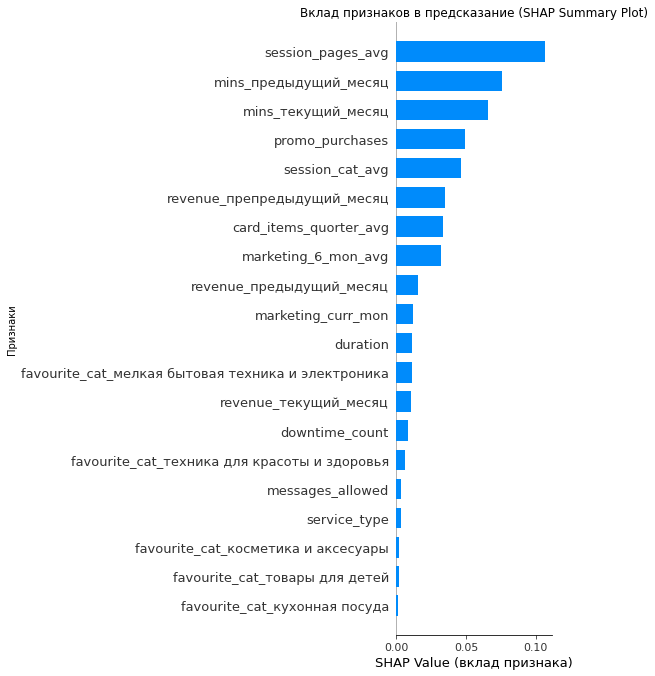

In [74]:
# Извлечение имён признаков
cat_ohe_pipeline = preprocessor.named_transformers_['ohe']
 
ohe_encoder = cat_ohe_pipeline.named_steps['ohe']
ohe_feature_names = ohe_encoder.get_feature_names_out(input_features=ohe_columns)
 
all_feature_names = np.concatenate([ohe_feature_names, ord_columns, num_columns])
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

feature_names = X_test_transformed_df.columns.tolist()

shap_values_class_1 = shap_values[:, :, 1]

# Построение bar-графика
shap.summary_plot(
    shap_values_class_1,
    features=X_test_transformed_df,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("Вклад признаков в предсказание (SHAP Summary Plot)")
plt.xlabel("SHAP Value (вклад признака)")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

### Выводы о значимости признаков

- **Наиболее значимые признаки:**
    - `session_pages_avg`: Этот признак имеет самый высокий вклад в предсказания модели. Это может означать, что среднее количество просмотренных страниц за сессию имеет сильное влияние на целевую переменную.
    - `mins_предыдущий_месяц` и `mins_текущий_месяц`: Время, проведённое пользователем в предыдущем и текущем месяцах, также играет важную роль, что указывает на значимость активности пользователей за определённый период.
- **Средне значимые признаки:**
    - `promo_purchases` (покупки по промоакциям): Покупки, связанные с промоакциями, влияют на поведение пользователей.
    - `session_cat_avg` и `card_items_quorter_avg`: Среднее количество категорий за сессию и среднее количество товаров в корзине за квартал также оказывают заметное влияние.
- **Меньше значимости:**
    - Признаки, связанные с доходами (`revenue_...`), имеют меньшее влияние, но всё ещё вносят вклад в предсказания.
    - Маркетинговые метрики, такие как `marketing_6_mon_avg` и `marketing_curr_mon`, имеют меньший вклад по сравнению с активностью пользователей.
- **Наименее значимые признаки:**
    - Категории, связанные с любимыми товарами (`favourite_cat_...`), а также тип сервиса (`service_type_...`), имеют минимальное влияние. Это может указывать на то, что пользовательские предпочтения и типы услуг не столь важны для целевой переменной в данном наборе данных.

## Сегментация покупателей

### Сегментация покупателей

- **Цель сегментации**:
    - Разделить покупателей на группы, основываясь на ключевых характеристиках из каждой из представленных категорий (групп признаков).
    - Понять, как особенности в каждой группе влияют на активность и прибыль.
- **Методология**:
    - Использовать метод кластеризации (например, K-Means или DBSCAN) для объединения покупателей в сегменты.
    - Для кластеризации можно использовать как все признаки, так и их сводные характеристики, такие как:
        - Среднее количество страниц, просмотренных за визит.
        - Средняя прибыль клиента.
        - Количество маркетинговых коммуникаций.
- **Подготовка данных**:
    - Выделить признаки из каждой категории.
    - Преобразовать категориальные признаки в числовые (если это ещё не сделано).
    - Применить масштабирование (например, StandardScaler или Mi

Организуем данные по группам:
- Коммуникация с клиентом
- Продуктовое поведение
- Поведение на сайте
- Финансовое поведение

In [75]:
# Группы признаков
communication_features_cat = [
    'service_type', 'messages_allowed'
]
communication_features_num = [
    'marketing_6_mon_avg', 'marketing_curr_mon', 'duration'
]
communication_features = np.concatenate([communication_features_cat, communication_features_num])

product_features_cat = [
    'favourite_cat'
]
product_features_num = [
    'session_cat_avg', 'card_items_quorter_avg'
]
product_features = np.concatenate([product_features_cat, product_features_num])

site_behavior_features = [
    'mins_предыдущий_месяц', 'mins_текущий_месяц',
    'session_pages_avg', 'downtime_count'
]

financial_features = [
    'revenue_препредыдущий_месяц', 'revenue_предыдущий_месяц', 'revenue_текущий_месяц'
]

Масштабируем числовые данные и кодируем категориальные. Обработка каждой группы отдельно позволит применять специфические подходы, если позже для одной из групп потребуется более сложная трансформация.

In [76]:
# Преобразование
communication_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), communication_features_num),
        ('cat', ohe_pipe, communication_features_cat)
    ]
)
product_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), product_features_num),
        ('cat', ohe_pipe, product_features_cat)
    ]
)

In [77]:
scaler = StandardScaler()

# Выбираем данные для каждого сегмента
communication_data = final_merged_df[communication_features]
product_data = final_merged_df[product_features]
site_behavior_data = final_merged_df[site_behavior_features]
financial_data = final_merged_df[financial_features]

# Масштабируем данные
scaler = StandardScaler()
communication_data_scaled = communication_preprocessor.fit_transform(communication_data)
product_data_scaled = product_preprocessor.fit_transform(product_data)
site_behavior_data_scaled = scaler.fit_transform(site_behavior_data)
financial_data_scaled = scaler.fit_transform(financial_data)

Применим K-Means для сегментации:

In [78]:
# Сегментация для коммуникации с клиентом
kmeans_communication = KMeans(n_clusters=3, random_state=42)
final_merged_df['Communication_Segment'] = kmeans_communication.fit_predict(communication_data_scaled)

# Сегментация для продуктового поведения
kmeans_product = KMeans(n_clusters=3, random_state=42)
final_merged_df['Product_Segment'] = kmeans_product.fit_predict(product_data_scaled)

# Сегментация для поведения на сайте
kmeans_site = KMeans(n_clusters=3, random_state=42)
final_merged_df['Site_Behavior_Segment'] = kmeans_site.fit_predict(site_behavior_data_scaled)

# Сегментация для финансового поведения
kmeans_financial = KMeans(n_clusters=3, random_state=42)
final_merged_df['Financial_Segment'] = kmeans_financial.fit_predict(financial_data_scaled)

### Выбор группы покупателей

Для последующего анализа выберем сегмент `Коммуникация`

#### Проверка состава сегментов
Для начала нужно понять, сколько клиентов попало в каждый сегмент и как они распределены.

0    497
1    480
2    319
Name: Communication_Segment, dtype: int64


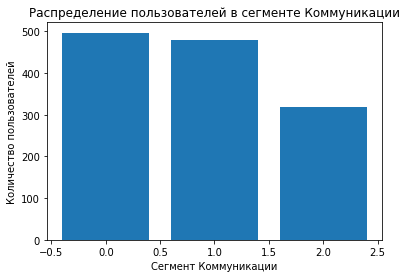

In [79]:
# Распределение по сегментам
segment_counts = final_merged_df['Communication_Segment'].value_counts()
print(segment_counts)

plt.bar(segment_counts.index, segment_counts.values)
plt.xlabel('Сегмент Коммуникации')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей в сегменте Коммуникации')
plt.show()

Данные показывают, что пользователи разделены на три сегмента:

- **Сегмент 0:** 497 пользователя (самый крупный сегмент)
- **Сегмент 1:** 480 пользователей
- **Сегмент 2:** 319 пользователей (самый маленький сегмент)

Анализ:

1. **Сегмент 0 (497 пользователей):**
    - Этот сегмент включает наибольшее количество пользователей.
    - Возможно, это наиболее активная или стандартная группа, которая соответствует обычному поведению пользователей.
2. **Сегмент 1 (480 пользователя):**
    - Второй по численности сегмент, чуть меньше, чем сегмент 0.
    - Возможно, здесь находятся пользователи с похожим, но менее выраженным паттерном поведения.
3. **Сегмент 2 (319 пользователей):**
    - Самый маленький сегмент.
    - Эта группа может быть уникальной или включать менее активных пользователей, требующих особого внимания для увеличения вовлеченности.

#### Средние значения признаков для каждого сегмента
Определим, как различные признаки из группы communication_features распределяются по сегментам.

Communication_Segment
0    4.154728
1    4.291042
2    4.362696
Name: marketing_6_mon_avg, dtype: float64


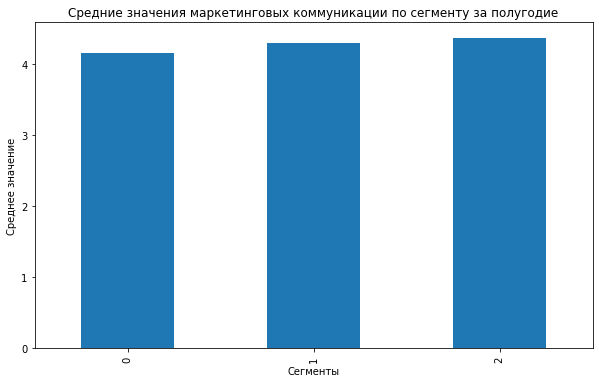

In [80]:
marketing_6_mon_analysis = final_merged_df.groupby('Communication_Segment')['marketing_6_mon_avg'].mean()
print(marketing_6_mon_analysis)

# Визуализация среднего значения для ключевых признаков
marketing_6_mon_analysis.T.plot(kind='bar', figsize=(10, 6))
plt.title('Средние значения маркетинговых коммуникации по сегменту за полугодие')
plt.xlabel('Сегменты')
plt.ylabel('Среднее значение')
plt.show()

**Анализ признака `marketing_6_mon_avg` по сегментам:**

1. **Описание признака**:
    - Признак "marketing_6_mon_avg" представляет собой среднее значение маркетинговых коммуникаций за последние шесть месяцев.
2. **Распределение средних значений по сегментам**:
    - **Сегмент 0**: Среднее значение маркетинговых коммуникаций составило 4.1.
    - **Сегмент 1**: Среднее значение чуть ниже — 4.2.
    - **Сегмент 2**: Наименьшее среднее значение — 4.25.
3. **Выводы по сегментам**:
    - Сегмент 2 имеет наиболее высокую интенсивность маркетинговых коммуникаций, что может свидетельствовать о более активном взаимодействии с этой группой.
    - Сегмент 1 имеет незначительные отличия в уровне маркетинговых коммуникаций
    - Сегменты 0 получает наименьшее количество маркетинговых усилий, что, возможно, связано с их меньшей вовлечённостью или сложностью в отклике на кампании.
4. **Рекомендации**:
    - Для **сегментов 1 и 2** можно поддерживать текущую стратегию маркетинговых коммуникаций, так как она, вероятно, наиболее успешна.
    - Для **сегмента 0** стоит рассмотреть возможность персонализированных предложений или изменения формата коммуникаций для повышения их эффективности.

Communication_Segment
0    3.609658
1    3.764583
2    5.000000
Name: marketing_curr_mon, dtype: float64


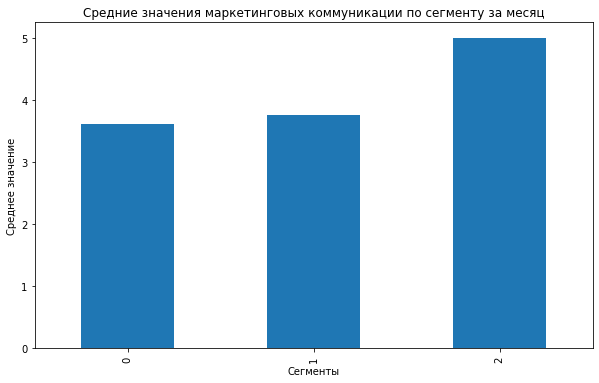

In [81]:
marketing_curr_mon_analysis = final_merged_df.groupby('Communication_Segment')['marketing_curr_mon'].mean()
print(marketing_curr_mon_analysis)

# Визуализация среднего значения для ключевых признаков
marketing_curr_mon_analysis.T.plot(kind='bar', figsize=(10, 6))
plt.title('Средние значения маркетинговых коммуникации по сегменту за месяц')
plt.xlabel('Сегменты')
plt.ylabel('Среднее значение')
plt.show()

**Анализ признака `marketing_curr_mon` по сегментам:**

1. **Описание признака**:
    - Признак "marketing_curr_mon" представляет собой среднее значение маркетинговых коммуникаций за текущий месяц.
2. **Распределение средних значений по сегментам**:
    - **Сегмент 0**: Самое низкое значение — 3.6.
    - **Сегмент 1**: Незначительно выше — 3.8.
    - **Сегмент 2**: Самое высокое значение — 5.
3. **Выводы по сегментам**:
    - **Сегмент 0** имеет самый низкий уровень активности. Возможно, коммуникации с этим сегментом менее эффективны или он менее вовлечён.
    - **Сегмент 1** также демонстрирует низкий уровень маркетинговых коммуникаций, однако немного выше сегмента 0.
    - **Сегмент 2** демонстрирует наибольшую активность в маркетинговых коммуникациях за текущий месяц. Это может быть связано с более активной стратегией работы с этим сегментом.
4. **Рекомендации**:
    - Для **сегментов 0 и 1** требуется пересмотреть подход к маркетинговым коммуникациям. Возможно, стоит внедрить более персонализированные стратегии или использовать новые каналы взаимодействия.
    - Для **сегмента 2** стоит сохранить текущий уровень взаимодействия, так как он приносит результаты.

Communication_Segment
0    820.490946
1    406.333333
2    559.943574
Name: duration, dtype: float64


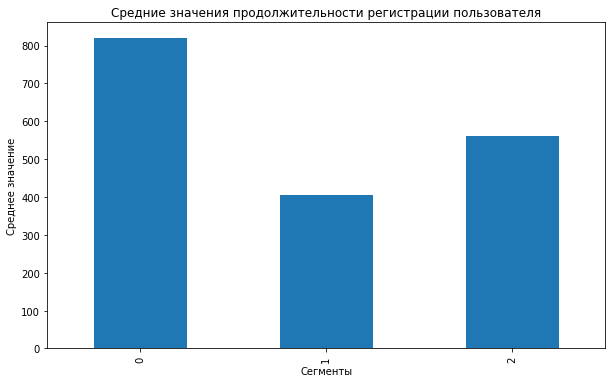

In [82]:
duration_analysis = final_merged_df.groupby('Communication_Segment')['duration'].mean()
print(duration_analysis)

# Визуализация среднего значения для ключевых признаков
duration_analysis.T.plot(kind='bar', figsize=(10, 6))
plt.title('Средние значения продолжительности регистрации пользователя')
plt.xlabel('Сегменты')
plt.ylabel('Среднее значение')
plt.show()

**Анализ признака `duration` по сегментам:**

1. **Описание признака**:
    - Признак "duration" отражает продолжительность времени, проведённого пользователями, предположительно в процессе взаимодействия с системой или сервисом.
2. **Распределение средних значений по сегментам**:
    - **Сегмент 0**: Средняя продолжительность составляет **800**.
    - **Сегмент 1**: Значительно выше — **400**.
    - **Сегмент 2**: Наивысший показатель — **580**.
3. **Выводы по сегментам**:
    - **Сегмент 0** обладает максимальной продолжительностью. Это может означать, что пользователи из этого сегмента больше заинтересованы в продукте или сервисе, а их взаимодействие более активное.
    - **Сегмент 1** имеет наименьшую продолжительность. Это может свидетельствовать о недостаточной вовлечённости или интересе пользователей из этого сегмента.
    - **Сегмент 2** демонстрирует хороший уровень активности, хотя и уступает сегменту 0.
4. **Рекомендации**:
    - Для **сегмента 0** важно сохранять и усиливать текущие стратегии, которые работают на вовлечённость.
    - Для **сегмента 1** необходимо рассмотреть причины низкой продолжительности. Возможно, стоит провести дополнительные исследования, чтобы выявить препятствия для вовлечения. Можно попробовать улучшить интерфейс, предложить дополнительные функции или провести кампании для повышения интереса.
    - Для **сегмента 2** можно поддерживать текущий уровень взаимодействия, но также изучить, что помогает пользователям из сегмента 0 достигать большего вовлечения.

#### Анализ распределения ключевых признаков
Для более глубокого анализа построим боксплоты для каждого признака, чтобы увидеть их распределение по сегментам.

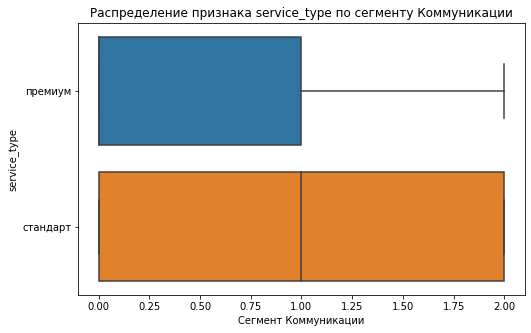

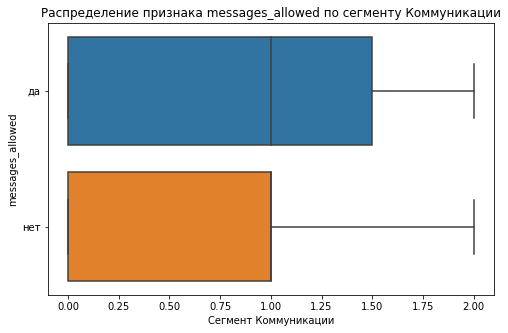

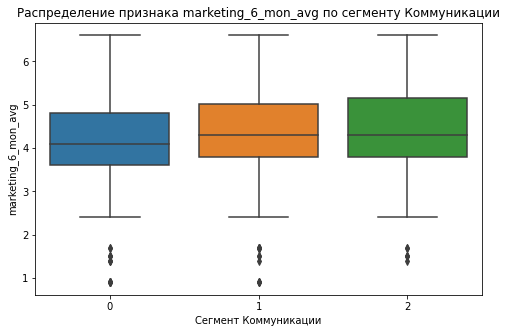

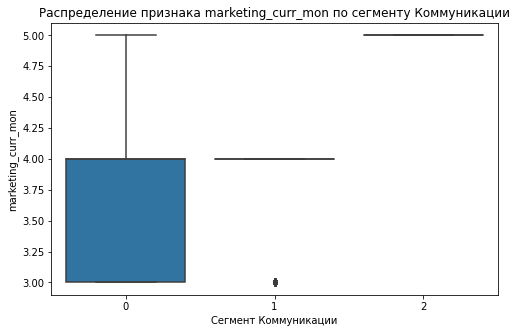

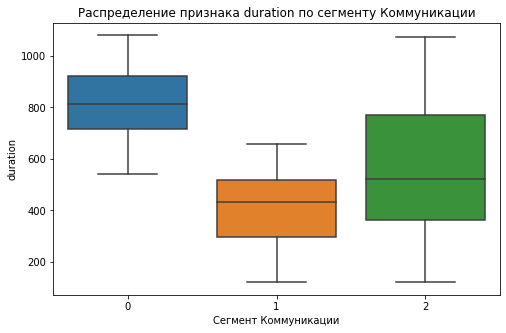

In [83]:
# Боксплоты для признаков коммуникации
for feature in communication_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Communication_Segment', y=feature, data=final_merged_df)
    plt.title(f'Распределение признака {feature} по сегменту Коммуникации')
    plt.xlabel('Сегмент Коммуникации')
    plt.ylabel(feature)
    plt.show()

1. **`service_type` (Тип обслуживания):**
    - В основном сегмент "0" включает премиум-обслуживание, в то время как сегменты "1" и "2" имеют больше стандартных пользователей.
    - Это может указывать на разные потребности и взаимодействие с клиентами в зависимости от типа их обслуживания.
2. **`messages_allowed` (Разрешение на сообщения):**
    - Сегменты "0" и "2" чаще разрешают сообщения, в отличие от сегмента "1".
    - Это может свидетельствовать о более высоком уровне взаимодействия в этих сегментах и открытости к коммуникации.
3. **`marketing_6_mon_avg` (Маркетинговая активность за 6 месяцев):**
    - Средние значения по всем сегментам схожи, однако диапазон варьируется.
    - В сегменте "0" активность менее варьируется, что может быть показателем более однородного поведения.
4. **`marketing_curr_mon` (Маркетинговая активность за последний месяц):**
    - Сегмент "0" демонстрирует минимальную активность по сравнению с остальными.
    - Сегмент "1" и "2" имеют схожие показатели, что может быть интересным для анализа их динамики.
5. **`duration` (Длительность):**
    - Сегмент "2" включает пользователей с наибольшей длительностью активности, а "0" — с минимальной.
    - Это может свидетельствовать о долгосрочной лояльности клиентов в сегменте "2".
  
**Общие выводы:**

- Сегменты различаются по параметрам, связанным с типом обслуживания, уровнем коммуникации и маркетинговой активности.
- Сегмент "2" выделяется как наиболее перспективный с точки зрения долгосрочной лояльности, хотя сегмент "0" может потребовать улучшений в маркетинговых коммуникациях.
- Эти выводы могут быть использованы для таргетинга сегментов с учетом их особенностей, таких как повышение маркетинговой активности или коммуникаций для сегмента "0".

#### Анализ активности сегментов
Проанализируем как сегменты различаются по целевому признаку

buying_activity        прежний уровень  снизилась
Communication_Segment                            
0                             0.583501   0.416499
1                             0.660417   0.339583
2                             0.611285   0.388715


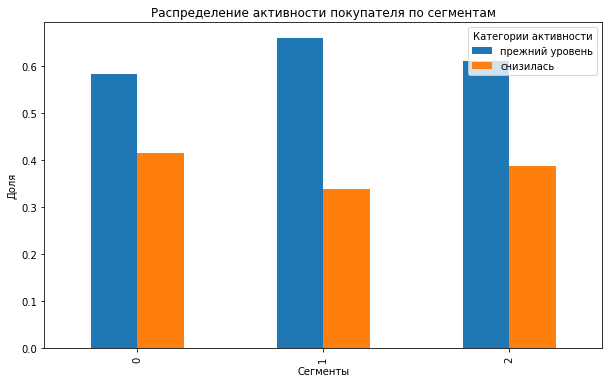

In [84]:
# Распределение покупательской активности по сегментам
activity_distribution = final_merged_df.groupby('Communication_Segment')['buying_activity'].value_counts(normalize=True).unstack()
print(activity_distribution)

# Визуализация активности
activity_distribution.plot(kind='bar', figsize=(10, 6))
plt.title("Распределение активности покупателя по сегментам")
plt.xlabel("Сегменты")
plt.ylabel("Доля")
plt.legend(title="Категории активности")
plt.show()

На основе представленного графика распределения покупательской активности по сегментам можно сделать следующие выводы:

**Сегмент 0:**

- **Прежний уровень активности** — около 58%.
- **Снижение активности** — около 42%.
- Это наиболее проблемный сегмент с точки зрения удержания клиентов, так как почти половина пользователей снизила свою активность.

**Сегмент 1:**

- **Прежний уровень активности** составляет примерно 65% пользователей.
- **Снижение активности** наблюдается у 35% пользователей.
- Этот сегмент демонстрирует высокий уровень стабильности активности, однако значительная доля клиентов (35%) снизила свою активность, что требует дальнейшего анализа и возможно целевых действий для их удержания

**Сегмент 2:**

- **Прежний уровень активности** — около 60%.
- **Снижение активности** — почти 40%.
- В этом сегменте доля снижения активности самая высокая, что может указывать на недостаточную эффективность текущих стратегий взаимодействия с клиентами. Требуется усиление коммуникаций и маркетинговых активностей..


**Рекомендации:**

1. **Сегмент 0**:
    - Приоритетно разработать меры для удержания клиентов.
    - Ввести дополнительные стимулы, такие как скидки или бонусы, чтобы привлечь клиентов обратно.
2. **Сегмент 1**:
    - Поддерживать существующие стратегии взаимодействия с клиентами.
    - Разработать программу удержания для тех, кто показывает снижение активности.
3. **Сегмент 2**:
    - Усилить маркетинговую активность, направленную на вовлечение клиентов, и предлагать персонализированные предложения.
    - Проводить анализ причин снижения активности, возможно, через опросы клиентов.

**Общий вывод:**

Сегменты 0 и 2 требуют внимания, особенно с точки зрения предотвращения дальнейшего снижения активности. Необходимо сфокусироваться на персонализированных маркетинговых стратегиях и анализе причин ухода клиентов.

### Выводы о сегментах

**Общий вывод:**

1. Клиенты распределены по сегментам, каждый из которых имеет свои особенности активности и поведения.
2. Наблюдается заметное снижение активности в нескольких сегментах, что свидетельствует о необходимости пересмотра стратегий удержания и взаимодействия с клиентами.
3. Наибольший приоритет должен быть отдан сегментам с максимальным снижением активности, чтобы предотвратить дальнейший отток пользователей и улучшить показатели их вовлеченности.

**Рекомендации для заказчика:**

1. **Мониторинг сегментов:**
    - Регулярно отслеживать динамику активности пользователей в каждом сегменте.
    - Использовать показатели для оценки эффективности текущих маркетинговых стратегий.
2. **Персонализированные стратегии:**
    - Разработать индивидуальные предложения и кампании для клиентов с учетом особенностей сегмента.
    - Использовать данные сегментации для таргетирования наиболее уязвимых групп.
3. **Программы лояльности:**
    - Ввести бонусные программы или скидки для стимуляции активности в сегментах, где снижение активности наиболее значительное.
    - Рассмотреть возможность внедрения системы вознаграждений для постоянных клиентов.
4. **Обратная связь от клиентов:**
    - Организовать опросы или интервью для понимания причин снижения активности.
    - Анализировать отзывы для улучшения качества услуг и продуктов.
5. **Инвестиции в удержание:**
    - Сосредоточиться на удержании клиентов в сегментах с наибольшим снижением активности.
    - Внедрить автоматизированные системы напоминаний, персонализированные рассылки или другие инструменты для повышения вовлеченности.
6. **Оптимизация взаимодействий:**
    - Проанализировать точки контакта с клиентами и устранить возможные барьеры.
    - Улучшить пользовательский опыт на всех этапах взаимодействия.

Эти шаги помогут не только удержать существующую клиентскую базу, но и повысить уровень вовлеченности и лояльности клиентов в долгосрочной перспективе.

## Общий вывод

**Задача проекта:**

Разработать решение для персонализации взаимодействия с клиентами интернет-магазина с целью удержания их активности и увеличения прибыльности.

---

### Этапы исследования:

1. **Предобработка данных:**
    - Проведена очистка, преобразование и объединение данных из различных источников.
    - Выполнен анализ пропусков, приведены данные к единому формату.
2. **Исследовательский анализ данных (EDA):**
    - Выявлены ключевые особенности клиентского поведения.
    - Оценены зависимости между признаками, в том числе с использованием корреляционного анализа.
3. **Сегментация клиентов:**
    - Использован алгоритм **KMeans** для выделения сегментов клиентов на основе их характеристик.
    - Проведён подробный анализ сегментов: коммуникация с клиентами, поведение на сайте, финансовое поведение, продуктовые предпочтения.
4. **Построение моделей:**
    - Для прогнозирования активности клиентов протестированы модели (например, DecisionTreeClassifier, SVC, LogisticRegression).
    - Лучшей моделью была выбрана модель на основе метрики **F1**, что позволяет учесть дисбаланс классов в данных.
    - Использован метод **SHAP** для анализа важности признаков и интерпретации модели.
5. **Рекомендации для сегментов:**
    - На основе анализа сегментов разработаны индивидуальные стратегии для повышения активности клиентов.
    - Определены сегменты, которые требуют приоритетного внимания.

---

### Рекомендации для заказчика:

1. **Оптимизация маркетинговых стратегий:**
    - Использовать персонализированные предложения для удержания клиентов из сегментов с высокой долей снижения активности.
    - Увеличить частоту и вариативность маркетинговых кампаний для наиболее "уходящих" клиентов.
2. **Вовлечение клиентов:**
    - В сегментах с низкой активностью предлагать бонусы, скидки, программы лояльности.
    - Развивать коммуникацию с клиентами через каналы, которые они предпочитают (например, мессенджеры или email).
3. **Анализ поведения:**
    - Регулярно обновлять сегментацию клиентов на основе новых данных.
    - Проводить клиентские опросы для более глубокого понимания их потребностей.
4. **Техническая интеграция:**
    - Интегрировать построенные модели прогнозирования в CRM системы для автоматизации маркетинговых процессов.
    - Периодически пересматривать метрики моделей, чтобы обеспечивать их актуальность.

---

**Итог:**

Проект успешно выделил ключевые клиентские сегменты, определил их особенности и разработал персонализированные стратегии. Использование предложенных решений позволит сократить отток клиентов, увеличить их активность и, как следствие, повысить прибыль компании.